### Imports

In [2]:
from functions.load_data import load_CIFAR_data, load_Google_Digit_Data, load_MNIST_data, shuffle_data
from functions.attacks import attackTestSet
from functions.models import buildReLuModel, buildTropicalModel
from tensorflow.keras import losses, initializers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

### PGD Experiment

In [ ]:
iterations = 500 #aribitrary
loss_object = losses.BinaryCrossentropy()
x_train, x_test, y_train, y_test = load_CIFAR_data()

for i in range(iterations):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) 

    reluModel = buildReLuModel(x_train, y_train)
    relu_x_test_att = attackTestSet(reluModel, x_test, y_test, loss_object, "ReLu")
    relu_pre_loss, relu_pre_acc = reluModel.evaluate(x_test, y_test)
    relu_post_loss, relu_post_acc = reluModel.evaluate(relu_x_test_att, y_test)

    tropModel1 = buildTropicalModel(x_train, y_train)
    trop_x_test_att1 = attackTestSet(tropModel1, x_test, y_test, loss_object, "Tropical")
    trop_pre_loss1, trop_pre_acc1 = tropModel1.evaluate(x_test, y_test)
    trop_post_loss1, trop_post_acc1 = tropModel1.evaluate(trop_x_test_att1, y_test)

    # - write to csv - 
    data = [relu_pre_loss, relu_pre_acc, relu_post_loss, relu_post_acc,trop_pre_loss1, trop_pre_acc1, trop_post_loss1, trop_post_acc1]
    with open('output3.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

### Initialization Parameter Experiment

In [3]:
iterations = 50 #aribitrary
loss_object = losses.BinaryCrossentropy()
x_train, x_test, y_train, y_test = load_CIFAR_data()
#x_train, x_test, y_train, y_test = load_MNIST_data()
#x_train, x_test, y_train, y_test = load_Google_Digit_Data(desired_classes=[1,4])

for i in range(iterations):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) 

    #reluModel = buildReLuModel(x_train, y_train)
    tropModel1 = buildTropicalModel(x_train, y_train, initializer_w = initializers.random_normal)
    tropModel2 = buildTropicalModel(x_train, y_train, initializer_w = initializers.RandomUniform(minval=0, maxval=1))
    tropModel3 = buildTropicalModel(x_train, y_train, initializer_w = initializers.Constant(value=0.5))
    tropModel4 = buildTropicalModel(x_train, y_train, initializer_w = initializers.RandomNormal(mean=0.5, stddev=0.005))

    #relu_x_test_att = attackTestSet(reluModel, x_test, y_test, loss_object, "ReLu")
    trop_x_test_att1 = attackTestSet(tropModel1, x_test, y_test, loss_object, "Tropical - Standard Random Normal")
    trop_x_test_att2 = attackTestSet(tropModel2, x_test, y_test, loss_object, "Tropical - U(0, 1)")
    trop_x_test_att3 = attackTestSet(tropModel3, x_test, y_test, loss_object, "Tropical - 0.5 vector")
    trop_x_test_att4 = attackTestSet(tropModel4, x_test, y_test, loss_object, "Tropical - N(0.5, 0.005)")
    
    #relu_pre_loss, relu_pre_acc = reluModel.evaluate(x_test, y_test)
    #relu_post_loss, relu_post_acc = reluModel.evaluate(relu_x_test_att, y_test)

    trop_pre_loss1, trop_pre_acc1 = tropModel1.evaluate(x_test, y_test)
    trop_post_loss1, trop_post_acc1 = tropModel1.evaluate(trop_x_test_att1, y_test)

    trop_pre_loss2, trop_pre_acc2 = tropModel2.evaluate(x_test, y_test)
    trop_post_loss2, trop_post_acc2 = tropModel2.evaluate(trop_x_test_att2, y_test)

    trop_pre_loss3, trop_pre_acc3 = tropModel3.evaluate(x_test, y_test)
    trop_post_loss3, trop_post_acc3 = tropModel3.evaluate(trop_x_test_att3, y_test)

    trop_pre_loss4, trop_pre_acc4 = tropModel4.evaluate(x_test, y_test)
    trop_post_loss4, trop_post_acc4 = tropModel4.evaluate(trop_x_test_att4, y_test)

    # - write to csv - 
    #data = [relu_pre_loss, relu_pre_acc, relu_post_loss, relu_post_acc, 
    data = [trop_pre_loss1, trop_pre_acc1, trop_post_loss1, trop_post_acc1,
            trop_pre_loss2, trop_pre_acc2, trop_post_loss2, trop_post_acc2,
            trop_pre_loss3, trop_pre_acc3, trop_post_loss3, trop_post_acc3,
            trop_pre_loss4, trop_pre_acc4, trop_post_loss4, trop_post_acc4]
    with open('output2.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

	0
Tropical model built. Elapsed time: 90.59 seconds /// 1.51 minutes.
Tropical model built. Elapsed time: 99.01 seconds /// 1.65 minutes.
Tropical model built. Elapsed time: 68.95 seconds /// 1.15 minutes.
Tropical model built. Elapsed time: 69.85 seconds /// 1.16 minutes.
Tropical - Standard Random Normal model 0% attacked.
Tropical - Standard Random Normal model 10% attacked.
Tropical - Standard Random Normal model 20% attacked.
Tropical - Standard Random Normal model 30% attacked.
Tropical - Standard Random Normal model 40% attacked.
Tropical - Standard Random Normal model 50% attacked.
Tropical - Standard Random Normal model 60% attacked.
Tropical - Standard Random Normal model 70% attacked.
Tropical - Standard Random Normal model 80% attacked.
Tropical - Standard Random Normal model 90% attacked.
Tropical - Standard Random Normal attack complete. Elapsed time: 257.81 seconds /// 4.30 minutes.
Tropical - U(0, 1) model 0% attacked.
Tropical - U(0, 1) model 10% attacked.
Tropical - 

KeyboardInterrupt: 

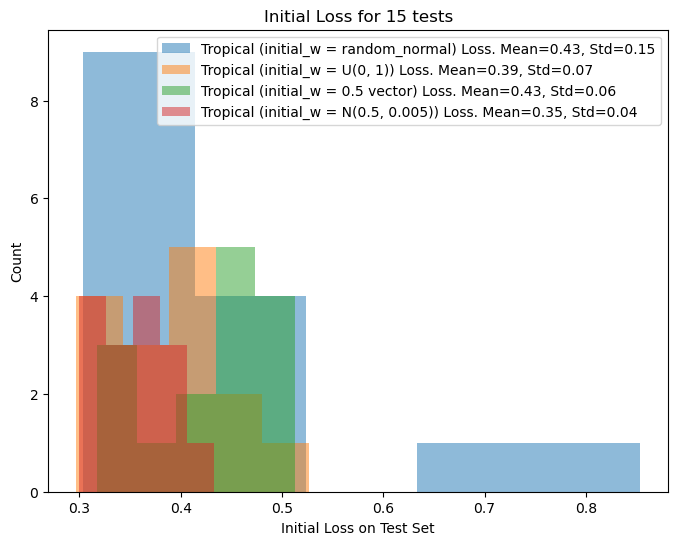

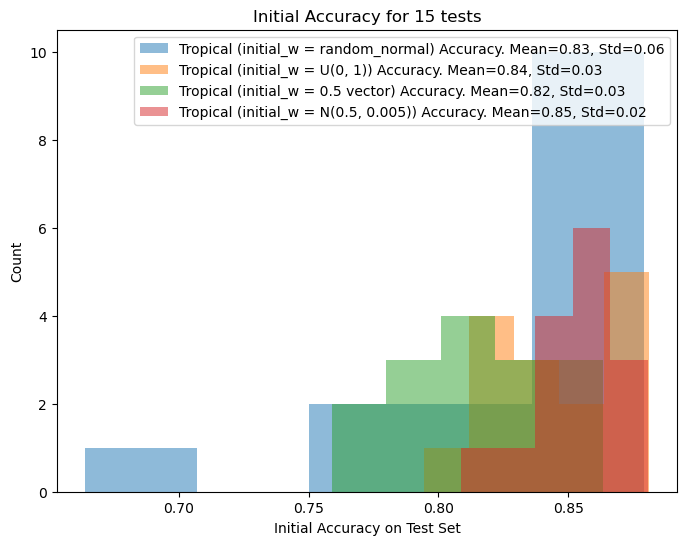

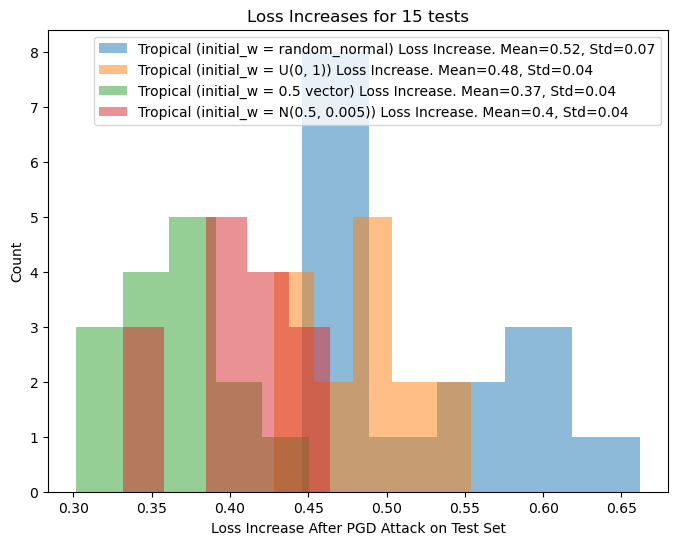

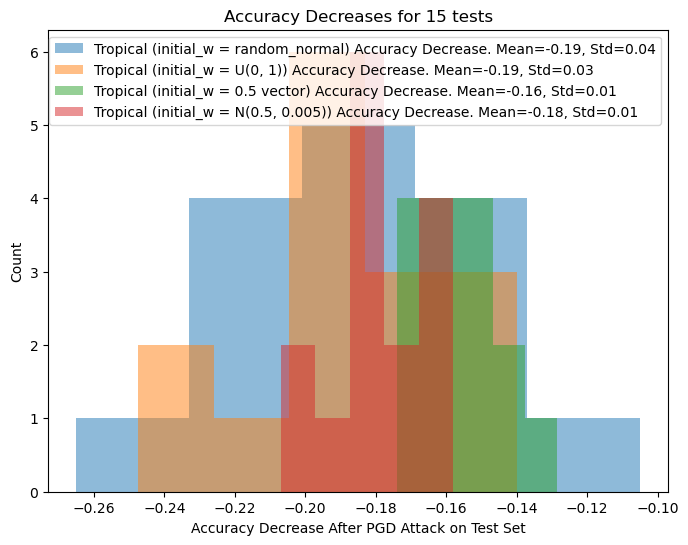

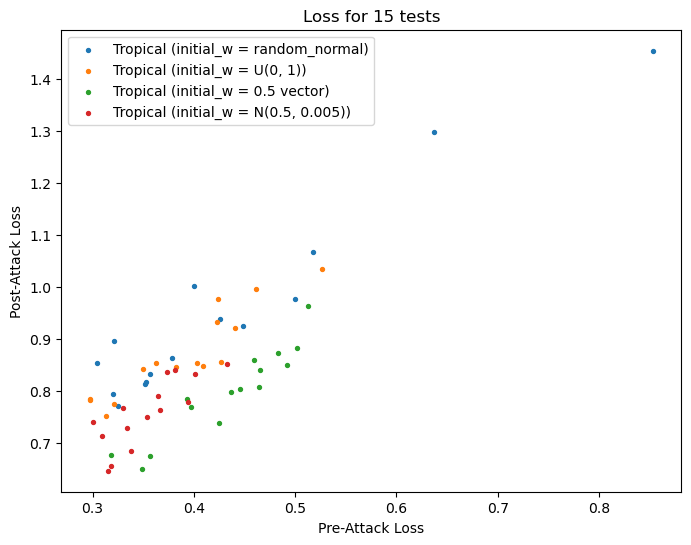

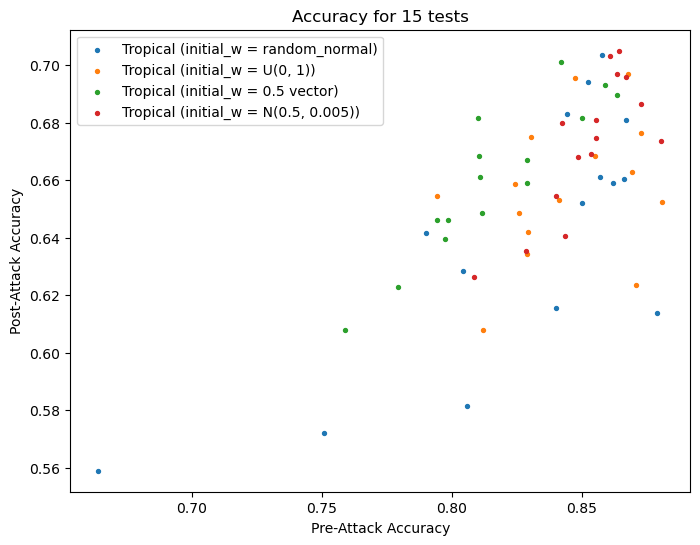

"\nplt.scatter(data['relu_loss_diff'], data['relu_acc_diff'], s=6, label=f'ReLU')\nplt.scatter(data['trop_loss_diff'], data['trop_acc_diff'], s=6, label=f'Tropical')\n#plt.ylim(0,1)\n#plt.xlim(0,1)\nplt.xlabel('Loss Difference After Attack')\nplt.ylabel('Accuracy Difference After Attack')\nplt.title(f'Loss Diff v Acc Diff for {rowNum} tests')\nplt.legend()\nplt.show()\n"

In [4]:
scat_size = 8
bin_num = 5
hist_wid = 8
hist_hei = 6
data = pd.read_csv("output2.csv")
rowNum = data.shape[0]

#data["relu_loss_diff"] = data['relu_post_loss'] - data['relu_pre_loss']
data["trop_loss_diff1"] = data['trop_post_loss1'] - data['trop_pre_loss1']
#data["relu_acc_diff"] = data['relu_post_acc'] - data['relu_pre_acc']
data["trop_acc_diff1"] = data['trop_post_acc1'] - data['trop_pre_acc1']

data["trop_loss_diff2"] = data['trop_post_loss2'] - data['trop_pre_loss2']
data["trop_acc_diff2"] = data['trop_post_acc2'] - data['trop_pre_acc2']

data["trop_loss_diff3"] = data['trop_post_loss3'] - data['trop_pre_loss3']
data["trop_acc_diff3"] = data['trop_post_acc3'] - data['trop_pre_acc3']

data["trop_loss_diff4"] = data['trop_post_loss4'] - data['trop_pre_loss4']
data["trop_acc_diff4"] = data['trop_post_acc4'] - data['trop_pre_acc4']

plt.figure(figsize=(hist_wid,hist_hei))
plt.hist(np.array(data["trop_pre_loss1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Loss. Mean={round(data["trop_pre_loss1"].mean(),2)}, Std={round(data["trop_pre_loss1"].std(),2)}')
plt.hist(np.array(data["trop_pre_loss2"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = U(0, 1)) Loss. Mean={round(data["trop_pre_loss2"].mean(),2)}, Std={round(data["trop_pre_loss2"].std(),2)}')
plt.hist(np.array(data["trop_pre_loss3"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = 0.5 vector) Loss. Mean={round(data["trop_pre_loss3"].mean(),2)}, Std={round(data["trop_pre_loss3"].std(),2)}')
plt.hist(np.array(data["trop_pre_loss4"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = N(0.5, 0.005)) Loss. Mean={round(data["trop_pre_loss4"].mean(),2)}, Std={round(data["trop_pre_loss4"].std(),2)}')
plt.xlabel('Initial Loss on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Loss for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.hist(np.array(data["trop_pre_acc1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Accuracy. Mean={round(data["trop_pre_acc1"].mean(),2)}, Std={round(data["trop_pre_acc1"].std(),2)}')
plt.hist(np.array(data["trop_pre_acc2"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = U(0, 1)) Accuracy. Mean={round(data["trop_pre_acc2"].mean(),2)}, Std={round(data["trop_pre_acc2"].std(),2)}')
plt.hist(np.array(data["trop_pre_acc3"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = 0.5 vector) Accuracy. Mean={round(data["trop_pre_acc3"].mean(),2)}, Std={round(data["trop_pre_acc3"].std(),2)}')
plt.hist(np.array(data["trop_pre_acc4"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = N(0.5, 0.005)) Accuracy. Mean={round(data["trop_pre_acc4"].mean(),2)}, Std={round(data["trop_pre_acc4"].std(),2)}')
plt.xlabel('Initial Accuracy on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
#plt.hist(np.array(data["relu_loss_diff"]), bins=bin_num, alpha=0.5, label=f'ReLU Loss Increase. Mean={round(data["relu_loss_diff"].mean(),2)}, Std={round(data["relu_loss_diff"].std(),2)}', color='blue')
plt.hist(np.array(data["trop_loss_diff1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Loss Increase. Mean={round(data["trop_loss_diff1"].mean(),2)}, Std={round(data["trop_loss_diff1"].std(),2)}')
plt.hist(np.array(data["trop_loss_diff2"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = U(0, 1)) Loss Increase. Mean={round(data["trop_loss_diff2"].mean(),2)}, Std={round(data["trop_loss_diff2"].std(),2)}')
plt.hist(np.array(data["trop_loss_diff3"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = 0.5 vector) Loss Increase. Mean={round(data["trop_loss_diff3"].mean(),2)}, Std={round(data["trop_loss_diff3"].std(),2)}')
plt.hist(np.array(data["trop_loss_diff4"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = N(0.5, 0.005)) Loss Increase. Mean={round(data["trop_loss_diff4"].mean(),2)}, Std={round(data["trop_loss_diff4"].std(),2)}')
plt.xlabel('Loss Increase After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Loss Increases for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
#plt.hist(np.array(data["relu_acc_diff"]), bins=bin_num, alpha=0.5, label=f'ReLU Accuracy Decrease. Mean={round(data["relu_acc_diff"].mean(),2)}, Std={round(data["relu_acc_diff"].std(),2)}', color='blue')
plt.hist(np.array(data["trop_acc_diff1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Accuracy Decrease. Mean={round(data["trop_acc_diff1"].mean(),2)}, Std={round(data["trop_acc_diff1"].std(),2)}')
plt.hist(np.array(data["trop_acc_diff2"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = U(0, 1)) Accuracy Decrease. Mean={round(data["trop_acc_diff2"].mean(),2)}, Std={round(data["trop_acc_diff2"].std(),2)}')
plt.hist(np.array(data["trop_acc_diff3"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = 0.5 vector) Accuracy Decrease. Mean={round(data["trop_acc_diff3"].mean(),2)}, Std={round(data["trop_acc_diff3"].std(),2)}')
plt.hist(np.array(data["trop_acc_diff4"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = N(0.5, 0.005)) Accuracy Decrease. Mean={round(data["trop_acc_diff4"].mean(),2)}, Std={round(data["trop_acc_diff4"].std(),2)}')
plt.xlabel('Accuracy Decrease After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Accuracy Decreases for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
#plt.scatter(data['relu_pre_loss'], data['relu_post_loss'], s=6, label=f'ReLU')
plt.scatter(data['trop_pre_loss1'], data['trop_post_loss1'], s=scat_size, label=f'Tropical (initial_w = random_normal)')
plt.scatter(data['trop_pre_loss2'], data['trop_post_loss2'], s=scat_size, label=f'Tropical (initial_w = U(0, 1))')
plt.scatter(data['trop_pre_loss3'], data['trop_post_loss3'], s=scat_size, label=f'Tropical (initial_w = 0.5 vector)')
plt.scatter(data['trop_pre_loss4'], data['trop_post_loss4'], s=scat_size, label=f'Tropical (initial_w = N(0.5, 0.005))')
plt.xlabel('Pre-Attack Loss')
plt.ylabel('Post-Attack Loss')
plt.title(f'Loss for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
#plt.scatter(data['relu_pre_acc'], data['relu_post_acc'], s=6, label=f'ReLU')
plt.scatter(data['trop_pre_acc1'], data['trop_post_acc1'], s=scat_size, label=f'Tropical (initial_w = random_normal)')
plt.scatter(data['trop_pre_acc2'], data['trop_post_acc2'], s=scat_size, label=f'Tropical (initial_w = U(0, 1))')
plt.scatter(data['trop_pre_acc3'], data['trop_post_acc3'], s=scat_size, label=f'Tropical (initial_w = 0.5 vector)')
plt.scatter(data['trop_pre_acc4'], data['trop_post_acc4'], s=scat_size, label=f'Tropical (initial_w = N(0.5, 0.005))')
plt.xlabel('Pre-Attack Accuracy')
plt.ylabel('Post-Attack Accuracy')
plt.title(f'Accuracy for {rowNum} tests')
plt.legend()
plt.show()
'''
plt.scatter(data['relu_loss_diff'], data['relu_acc_diff'], s=6, label=f'ReLU')
plt.scatter(data['trop_loss_diff'], data['trop_acc_diff'], s=6, label=f'Tropical')
#plt.ylim(0,1)
#plt.xlim(0,1)
plt.xlabel('Loss Difference After Attack')
plt.ylabel('Accuracy Difference After Attack')
plt.title(f'Loss Diff v Acc Diff for {rowNum} tests')
plt.legend()
plt.show()
'''